<a href="https://www.kaggle.com/code/andreynesterov/digit-recognizer-pca-votingclassifier?scriptVersionId=125182098" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

1. [Introduction](#introduction)
1. [Data Collection](#datacollection)
1. [Data Analysis](#dataanalysis)
    1. [Explore Dataset](#exploredataset)
    1. [Explore Target Variable](#exploretargetvariable)
    1. [Data Visualization](#datavisualization)
1. [Data Preprocessing](#datapreprocessing)
    1. [PCA](#dppca)
    1. [Deskew](#dpdeskew)
    1. [Data Augmentation](#dpdataaugmentation)
    1. [Pipeline](#dppipeline)
1. [Model Training and Evaluation](#trainandevaluate)
    1. [Estimate PCA params](#estimatepcaparams)
    1. [Estimate Scalers](#estimatescalers)
    1. [Estimate Deskew](#estimatedeskew)
    1. [Estimate Different Models (default params)](#estimatedifferentmodels)
    1. [Fine-tuning](#finetuning)
         1. [SVC](#finetuningsvc)
         1. [Logistic Regression](#finetuninglr)
         1. [RandomForestClassifier](#finetuningrf)
         1. [ExtraTreesClassifier](#finetuninget)
         1. [KNeighborsClassifier](#finetuningknn)
         1. [HistGradientBoostingClassifier](#finetuninghb)
         1. [AdaBoostClassifier (base: HistGradientBoostingClassifier)](#finetuningadbhb)
         1. [AdaBoostClassifier (base: ExtraTreesClassifier)](#finetuningadbet)
         1. [AdaBoostClassifier (base: GaussianNB)](#finetuningadbgnb)
    1. [Estimations Results](#estimationsresults)
    1. [Ensemble learning](#ensemblelearning)
        1. [VotingClassifier](#votingclassifier)
1. [Submission](#submission)
1. [Conclusion](#conclusion)

<center>
<div style="color:;
           display:fill;
           border-radius:5px;
           background-color: lightgray;
           font-size:110%;
           letter-spacing:0.5px">

<h2 style="padding: 10px;
              color:white;">MNIST: Digits Recognizer
</h2>
</div>

# Introduction <a class="anchor" id="introduction"></a>

In this notebook, we will explore the popular MNIST dataset which contains a large number of images of handwritten digits. Our goal is to train a classifier (without using of neural networks) that can accurately recognize the digits in these images.

This Notebook Covers:

1. Exploratory Data Analysis
1. Building preprocessing pipeline
1. Data augmentation
1. Comparison of different models' baseline scores
1. Tuning best models
1. Evaluation ensemble classifiers
1. Final submission (achieved Public Score 0.992).

Overall, this notebook serves as an introduction to image classification with machine learning and provides insights into the techniques and tools used for this task.

In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import functools
import re
import copy
import imgaug.augmenters as iaa
import xgboost as xgb
from mlxtend import classifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, cross_val_predict, learning_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Binarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score, make_scorer,roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
from skopt import BayesSearchCV, space, plots
from scipy.stats import randint
from scipy.ndimage import interpolation
from IPython.display import Markdown, display
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

# to make this notebook's output stable across runs
np.random.seed(42)

warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning))

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

verbose_tuning = 0

def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")

## Data Collection

In [3]:
competition = "digit-recognizer"
if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"
    
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Data Analysis <a class="anchor" id="dataanalysis"></a>

## Explore Dataset <a class="anchor" id="exploredataset"></a>

Explore the MNIST dataset by analyzing its distribution, visualizing some of its samples.

In [116]:
print(f'Train dataset shape:\t {train_data.shape}',
    f'\nTest dataset shape:\t {test_data.shape}')

Train dataset shape:	 (42000, 785) 
Test dataset shape:	 (28000, 784)


In [117]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check for null and missing values

In [119]:
print('Train dataset, missing values:', train_data.isna().sum().sum())
print('Test dataset, missing values:', test_data.isna().sum().sum())

Train dataset, missing values: 0
Test dataset, missing values: 0


There are no missing values in the train and test datasets. So there are no corrupted images

### Explore Target Variable <a class="anchor" id="exploretargetvariable"></a>

In [210]:
def countplot_target_var(df, label, title):
    ax = sns.countplot(x=label, data=df)
    ax.figure.suptitle(title)
    for container in ax.containers:
        ax.bar_label(container)

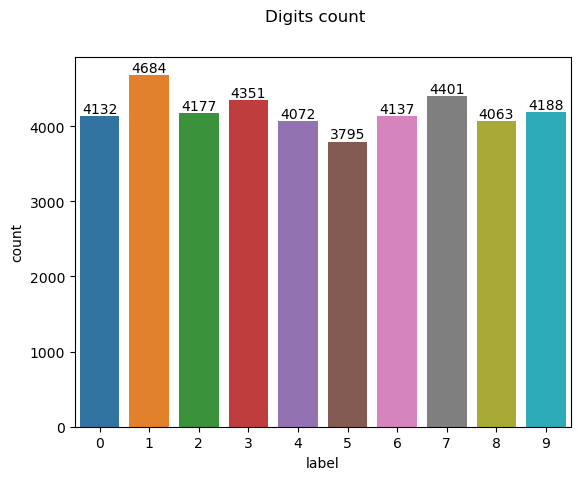

In [120]:
countplot_target_var(train_data, 'label', 'Digits count')

It looks nearly balanced.

### Data Visualization <a class="anchor" id="datavisualization"></a>

Create function to plot digits

In [96]:
def plot_digits(instances, actual_labels, predicted_labels, images_per_row=10, figsize=(8,8), **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    fig = plt.figure(figsize=figsize)
    for i in range(len(padded_instances)):
        ax = fig.add_subplot(n_rows, images_per_row, i + 1)
        grid_data = padded_instances[i].reshape(28,28)
        plt.imshow(grid_data, cmap = mpl.cm.binary, interpolation="nearest")
        actual_title = f'Actual: {actual_labels[i]}' if len(actual_labels) else ''
        predicted_title = f'\nPredicted: {predicted_labels[i]}' if len(predicted_labels) else ''
        ax.set_title(f'{actual_title}{predicted_title}')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.patch.set_linewidth('1')
        ax.spines['bottom'].set_color('lightgray')
        ax.spines['top'].set_color('lightgray') 
        ax.spines['right'].set_color('lightgray')
        ax.spines['left'].set_color('lightgray')
    fig.tight_layout()

Plot one random digit.

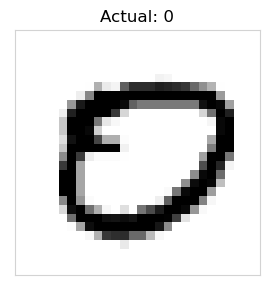

In [122]:
example_index = randint.rvs(0, len(train_data)-1, size=1)[0]
example_image = train_data.iloc[example_index, 1:785]
example_label = train_data.iloc[example_index, 0]
plot_digits([example_image], [example_label], [], images_per_row=1, figsize=(3,3))

Plot multiple random digits

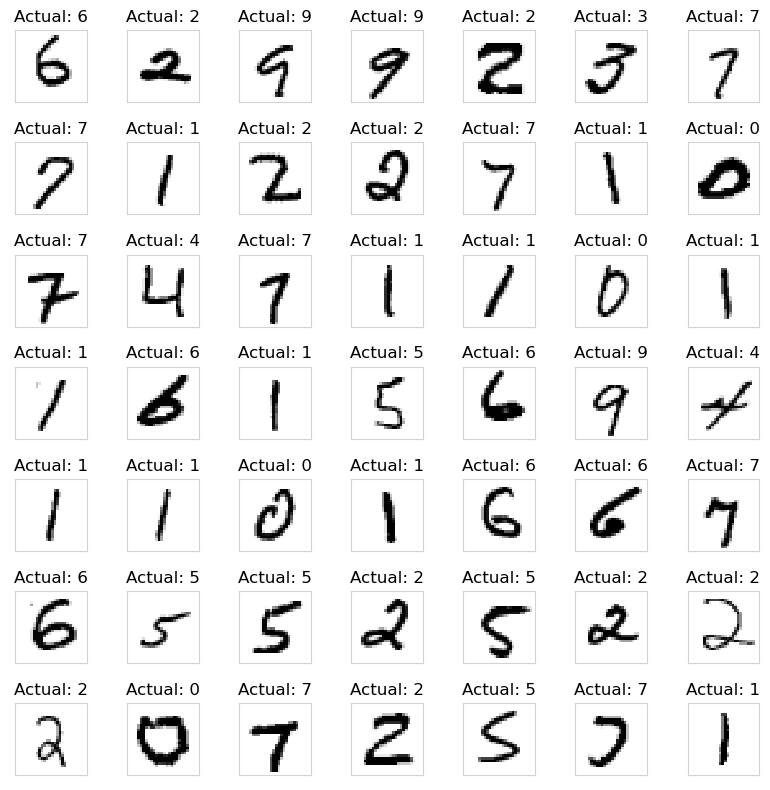

In [123]:
exmaple_indexes = randint.rvs(0, len(train_data)-1, size=49)
example_images = train_data.iloc[exmaple_indexes, 1:785].to_numpy()
example_labels = train_data.iloc[exmaple_indexes, 0].to_numpy()
plot_digits(example_images, example_labels, [], images_per_row=7)

#### t-SNE

In [86]:
def plot_tsne(data2D, labels, title):
    plt.scatter(data2D[:, 0], data2D[:, 1], s=5, c=labels, cmap='Spectral')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

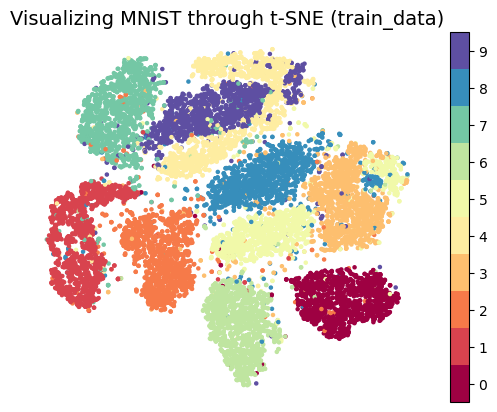

In [91]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=100, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
tsne_subset_size=15000
train_data_subset = train_data.loc[:(tsne_subset_size-1)].drop("label", axis=1)
train_data_labels_subset = train_data.loc[:(tsne_subset_size-1), 'label'].to_numpy()
train_data_tsne_reduced = pca_tsne.fit_transform(train_data_subset)
plot_tsne(train_data_tsne_reduced, train_data_labels_subset, 'Visualizing MNIST through t-SNE (train_data)')

We see that the classes of objects are well separated from each other in the visualization, which indicates the high quality of the data and the possibility of using machine learning models for classification tasks. Some objects belonging to different classes may be close to each other, which may indicate the difficulty in separating them by machine learning models.

# Data Preprocessing <a class="anchor" id="datapreprocessing"></a>

In [37]:
X_full = train_data.drop("label", axis=1)
y_full = train_data["label"]
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, 
                                              test_size=0.10, stratify = y_full)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
print(f'Train shape. \t\tX: {X_train.shape}, y: {y_train.shape}',
    f'\nValidation shape. \tX: {X_val.shape}, y: {y_val.shape}')

Train shape. 		X: (37800, 784), y: (37800,) 
Validation shape. 	X: (4200, 784), y: (4200,)


## PCA <a class="anchor" id="dppca"></a>

In [125]:
def plot_pca(pca, n_comp_example, ax, title):
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    cev_example = np.cumsum(pca.explained_variance_ratio_[:n_comp_example+1])[-1]
    ax.hlines(y=cev_example, xmin=0, xmax=n_comp_example, color='r', ls='--', lw=1)
    ax.vlines(x=n_comp_example, ymin=0, ymax=cev_example, color='r', ls='--', lw=1)
    ax.plot([n_comp_example], [cev_example], "ro")
    ax.set_xticks(list(ax.get_xticks()) + [n_comp_example])
    ax.set_yticks(list(ax.get_yticks()) + [round(cev_example, 2)])
    ax.set_xlim(0, pca.n_components+round(pca.n_components*0.05, 0))
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Cumulative explained variance')
    ax.grid()
    ax.set_title(title)

Plot the cumulative explained variance.

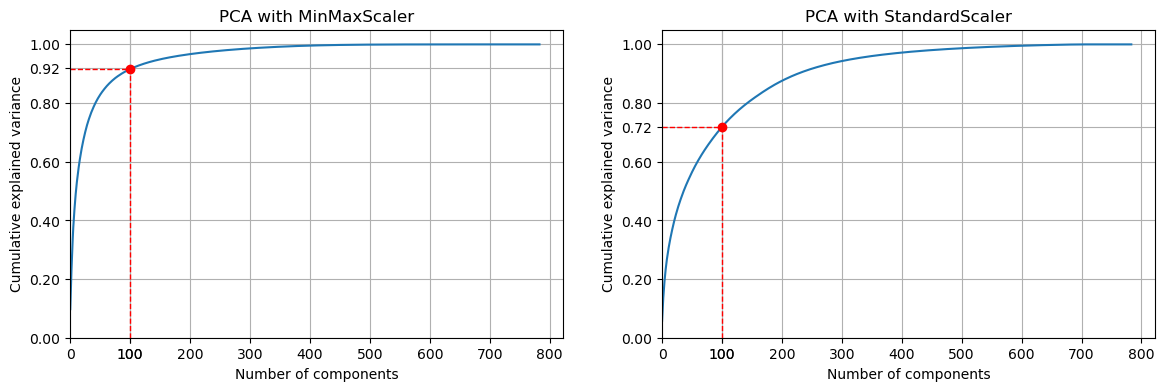

In [126]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4))
X_train_scaled1 = MinMaxScaler().fit_transform(X_train)
X_train_scaled2 = StandardScaler().fit_transform(X_train)
pca1 = PCA(n_components=X_train.shape[1]).fit(X_train_scaled1)
pca2 = PCA(n_components=X_train.shape[1]).fit(X_train_scaled2)
plot_pca(pca1, 100, ax0, "PCA with MinMaxScaler")
plot_pca(pca2, 100, ax1, "PCA with StandardScaler")
plt.show()

We see that 100 components describe about 92% of the variance with MinMaxScaler. PCA with MinMaxScaler also performs better than StandardScaler. We will check the performance with the following models.

Let's see how the digits look like after the reconstruction.

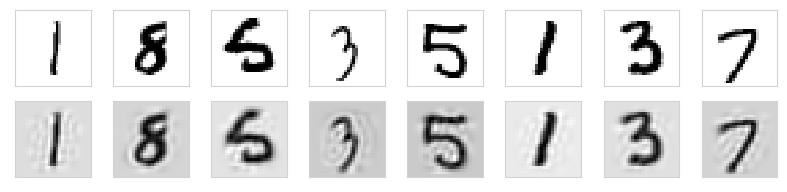

In [127]:
random_indexes = randint.rvs(0, len(X_train)-1, size=8)
example_images = X_train.iloc[random_indexes]
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_train_pca_inverted = pca.inverse_transform(X_train_pca)
example_images_pca_inverted = X_train_pca_inverted[random_indexes]
plot_digits(np.concatenate([example_images, example_images_pca_inverted]), 
            [], [], images_per_row=8, figsize=(8,2))

The quality of the reconstructed images has decreased, but the numbers are still recognizable. Of course, it depends on the number of components.

## Deskew <a class="anchor" id="dpdeskew"></a>

Handwritten digits are skewed. So, we will try to deskew them and check the performance in the training section.

In [38]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [39]:
X_train_deskewed = np.apply_along_axis(lambda x: deskew(x.reshape(28,28)).flatten(), axis=1, arr=X_train.astype(np.uint8).to_numpy())
X_val_deskewed = np.apply_along_axis(lambda x: deskew(x.reshape(28,28)).flatten(), axis=1, arr=X_val.astype(np.uint8).to_numpy())
X_full_deskewed = np.apply_along_axis(lambda x: deskew(x.reshape(28,28)).flatten(), axis=1, arr=X_full.astype(np.uint8).to_numpy())
test_data_deskewed = np.apply_along_axis(lambda x: deskew(x.reshape(28,28)).flatten(), axis=1, arr=test_data.astype(np.uint8).to_numpy())

In [19]:
def plot_deskewed_images(df, df_deskewed, size=8):
    example_indexes = randint.rvs(0, len(df)-1, size=size)
    original_images = df.iloc[example_indexes]
    deskewed_images = df_deskewed[example_indexes]
    plot_digits(original_images, [], [], images_per_row=8, figsize=(10,2))
    plt.suptitle('Original images')
    plt.show()
    plot_digits(deskewed_images, [], [], images_per_row=8, figsize=(10,2))
    plt.suptitle('Deskewed images')
    plt.show()

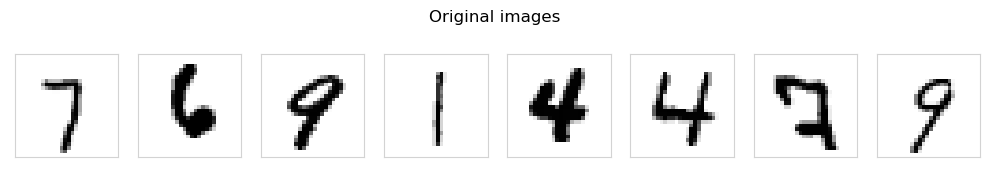

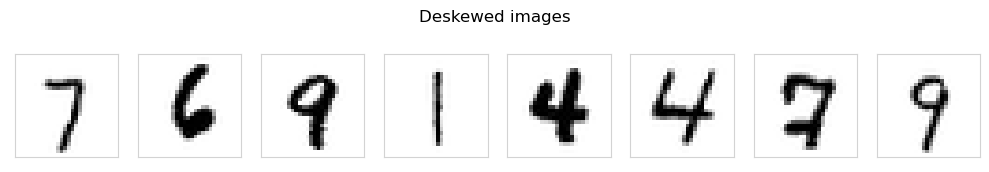

In [22]:
plot_deskewed_images(X_train, X_train_deskewed, 8)

Let's visualize the deskewed data using t-SNE.

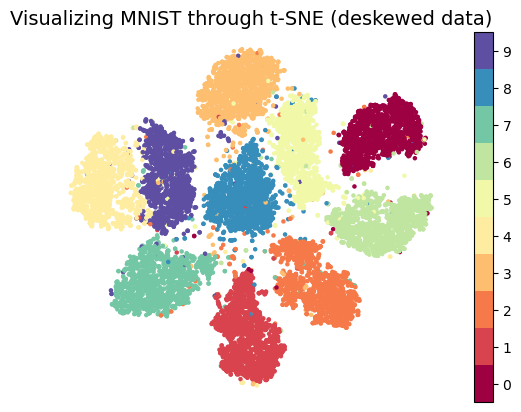

In [92]:
X_train_deskewed_tsne_reduced = pca_tsne.fit_transform(X_train_deskewed[:tsne_subset_size])
plot_tsne(X_train_deskewed_tsne_reduced, y_train[:tsne_subset_size], 'Visualizing MNIST through t-SNE (deskewed data)')

Clusters became more visually separable after applying deskew.

### Data augmentation <a class="anchor" id="dpdataaugmentation"></a>

Create functions to augment data.

In [81]:
def shift_image(image, dx, dy):
    shifted_image = interpolation.shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

def rotate_image(image, angle):
    rotate_augmenter = iaa.Rotate(angle)
    return rotate_augmenter.augment_image(image).flatten()

def scale_image(image, scale):
    h, w = image.shape
    seq = iaa.Sequential([
        iaa.Affine(scale=(scale)),
        iaa.CropToFixedSize(width=w, height=h, position='center')
    ])
    augmented_image = seq(image=image)
    return augmented_image.flatten()

def get_augmented_data(X_data, y_data, shift=True, rotate=True, scale=True):
    if isinstance(X_data, pd.DataFrame) or isinstance(X_data, pd.Series):
        X_data = X_data.astype(np.uint8).to_numpy()
    if isinstance(y_data, pd.DataFrame) or isinstance(y_data, pd.Series):
        y_data = y_data.to_numpy()
    X_augmented = [X_data]
    y_augmented = [y_data]
    if shift:
        for dx, dy in ((0, 1), (1, 0), (-1, 0), (0, -1)):
            shifted_images = np.apply_along_axis(lambda x, dx, dy: shift_image(x.reshape(28, 28), dx, dy), 
                                                 axis=1, arr=X_data, dx=dx, dy=dy)
            X_augmented.append(shifted_images)
            y_augmented.append(y_train)
    if rotate:
        for angle in [10, -10]:
            rotated_images = np.apply_along_axis(lambda x, angle: rotate_image(x.reshape(28, 28), angle), 
                                                 axis=1, arr=X_data, angle=angle)
            X_augmented.append(rotated_images)
            y_augmented.append(y_train)
    if scale:
        for scale in [1.08, 0.92]:
            scaled_images = np.apply_along_axis(lambda x, scale: scale_image(x.reshape(28, 28), scale),
                                                axis=1, arr=X_data, scale=scale)
            X_augmented.append(scaled_images)
            y_augmented.append(y_train)
    X_augmented_all = np.concatenate(X_augmented)
    y_augmented_all = np.concatenate(y_augmented)
    return (X_augmented_all, y_augmented_all)

Visualize random augmented digit.

#### <div style="color: black;">Augmentation: Shifting, Rotation, Scale</div>

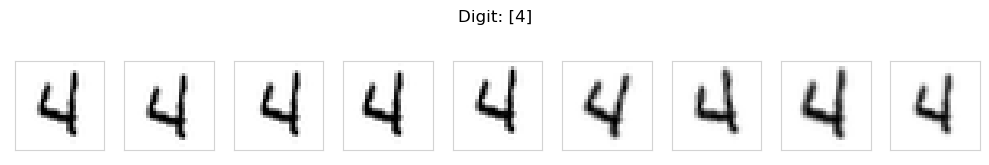

In [133]:
example_indexes = randint.rvs(0, len(X_train_deskewed)-1, size=1)
example_images = X_train_deskewed[example_indexes]
example_labels = y_train[example_indexes]
augmented_images, _ = get_augmented_data(example_images, example_labels)
display(Markdown(f'#### <div style="color: black;">Augmentation: Shifting, Rotation, Scale</div>'))
plot_digits(augmented_images, [], [], images_per_row=9, figsize=(10,2))
plt.suptitle(f'Digit: {y_train[example_indexes]}')
plt.show()

Creation of augmented data for deskewed images.

In [82]:
X_train_des_aug0, y_train_aug0 = get_augmented_data(X_train_deskewed, y_train, 
                                                    shift=True, rotate=False, scale=True)
print(f'Train shape. \tX: {X_train_deskewed.shape}, y: {y_train.shape}')
print(f'Train (augmented) shape. \tX: {X_train_des_aug0.shape}, y: {y_train_aug0.shape}')
print('Proportion: \t{:.0f}:1'.format(X_train_des_aug0.shape[0]/X_train_deskewed.shape[0]))

Train shape. 	X: (37800, 784), y: (37800,)
Train (augmented) shape. 	X: (264600, 784), y: (264600,)
Proportion: 	7:1


Shuffle of the augmented training data.

In [83]:
shuffle_idx = np.random.permutation(len(X_train_des_aug0))
X_train_des_aug = X_train_des_aug0[shuffle_idx]
y_train_aug = y_train_aug0[shuffle_idx]

Visualize some digits to make sure everything is correct after the augmentation and shuffling.

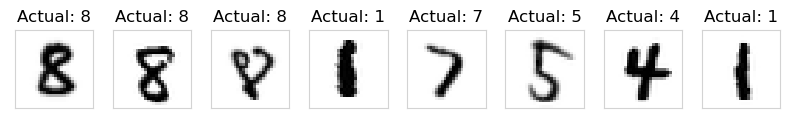

In [97]:
exmaple_indexes = randint.rvs(0, len(X_train_des_aug)-1, size=8)
example_images = X_train_des_aug[exmaple_indexes]
example_labels = y_train_aug[exmaple_indexes]
plot_digits(example_images, example_labels, [], images_per_row=8, figsize=(8,2))

Let's look at the augmented data using t-SNE.

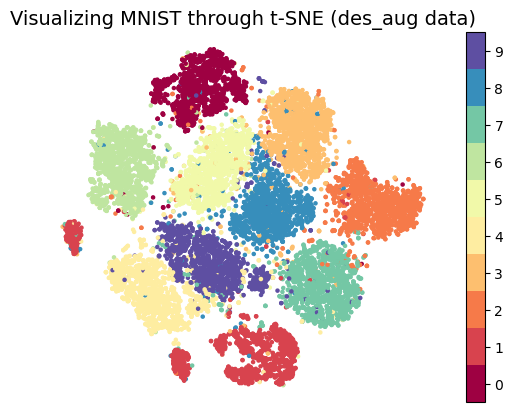

In [94]:
X_train_des_aug_tsne_reduced = pca_tsne.fit_transform(X_train_des_aug[:tsne_subset_size])
plot_tsne(X_train_des_aug_tsne_reduced, y_train_aug[:tsne_subset_size], 'Visualizing MNIST through t-SNE (des_aug data)')

## Pipeline <a class="anchor" id="dppipeline"></a>

This is the final pipeline, given the performance estimates below.

In [137]:
preprocessor = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=75))
])

In [138]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', None)
], verbose=False)

Deskewing data is a time-consuming process, so we will not create a separate transformer for it and just use the X_train_deskewed, X_val_deskewed, X_full_deskewed, test_data_deskewed and X_train_des_aug variables.

# Model Training and Evaluation <a class="anchor" id="trainandevaluate"></a>

Creating classes for reporting. Instead of using separate functions, I also created EstimatorReport and GridSearchReport classes for reporting functionality.

In [16]:
import scikitplot as skplt

class EstimatorReport():
    """
    A class used for generating a report on an estimator's performance 

    Attributes
    ----------
    X_val : np.ndarray
        Validation dataset features.
    y_val : np.ndarray
        Validation dataset labels.
    X_train : np.ndarray
        Training dataset features.
    y_train : np.ndarray
        Training dataset labels.
    estimator : estimator object
        Scikit-learn estimator object.
    estimator_name : str
        Name of the estimator.
    plot_micro : bool
        Whether micro average ROC curve should be plotted.
    plot_macro : bool
        Whether macro average ROC curve should be plotted.
    metrics_calculated : bool
        Whether the performance metrics have been calculated.

    Methods
    -------
    calculate_metrics()
        Calculates accuracy, confusion matrix, classification report and predicted probabilities
        based on the validation set and sets metrics_calculated flag to True.
    plot_curves(figsize=(18, 4))
        Plots ROC and PR curves and learning curve based on the validation set.
    display_report(figsize=(10, 5))
        Displays a report on estimator's performance based on validation set.
    __plot_confusion_matrix(ax)
        Plots confusion matrix.
    __plot_classification_report(ax)
        Plots classification report.
    """
    def __init__(
        self,
        estimator,
        X_val: np.ndarray,
        y_val: np.ndarray,
        X_train: np.ndarray,
        y_train: np.ndarray,
        estimator_name: str,
    ) -> None:
        self.X_val = X_val
        self.y_val = y_val
        self.X_train = X_train
        self.y_train = y_train
        self.estimator = estimator
        self.estimator_name = estimator_name
        self.plot_micro = False
        self.plot_macro = False
        self.metrics_calculated = False
    
    def calculate_metrics(self) -> None:
        self.y_val_predicted = self.estimator.predict(self.X_val)
        self.accuracy = accuracy_score(self.y_val, self.y_val_predicted)
        self.conf_mx = confusion_matrix(self.y_val, self.y_val_predicted)
        self.classif_report = classification_report(
            self.y_val, self.y_val_predicted, output_dict=True
        )
        try:
            self.y_val_probas = self.estimator.predict_proba(self.X_val)
        except:
            self.y_val_probas = self.estimator.decision_function(self.X_val)
        self.metrics_calculated = True
        
    def plot_curves(self, figsize=(18, 4)) -> None:
        if not self.metrics_calculated:
            self.calculate_metrics()
        fig, axes = plt.subplots( 
            1, 3, figsize=figsize, sharex=False, 
            gridspec_kw={'width_ratios': [1, 1, 1]}, dpi=100
        )
        skplt.metrics.plot_roc(
            y_true=self.y_val, y_probas=self.y_val_probas, ax=axes[0], 
            title='ROC curve', plot_micro=self.plot_micro, plot_macro=self.plot_macro
        )
        skplt.metrics.plot_precision_recall(
            y_true=self.y_val, y_probas=self.y_val_probas, ax=axes[1], 
            title='PR curve', plot_micro=self.plot_micro
        )
        skplt.estimators.plot_learning_curve(
            self.estimator, self.X_train, self.y_train, ax=axes[2]
        )
        axes[0].grid()
        axes[1].grid()
        
    def display_report(self, figsize=(10, 5)) -> None:
        if not self.metrics_calculated:
            self.calculate_metrics()
        display(Markdown(f'### <span style="color: black;">Evaluation on the Validation Set (estimator: {self.estimator_name})</span>'))
        display(Markdown('Accuracy: {:.4f}%'.format(self.accuracy*100)))
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize, sharex=False, 
                                   gridspec_kw={'width_ratios': [1, 2.2]}, dpi=100)
        self.__plot_classification_report(ax0)
        self.__plot_confusion_matrix(ax1)
        fig.tight_layout()
        plt.show()
        
    def __plot_confusion_matrix(self, ax) -> None:
        norm_conf_mx = self.conf_mx.astype('float') / self.conf_mx.sum(axis=1, keepdims=True)
        np.fill_diagonal(norm_conf_mx, 0)
        sns.heatmap(
            norm_conf_mx, ax=ax, 
            annot=False, cmap=plt.cm.gray, cbar=False
        )
        plt.title('Confusion matrix')
        thresh = norm_conf_mx.max() / 2
        for i, j in itertools.product(range(self.conf_mx.shape[0]), range(self.conf_mx.shape[1])):
            plt.text(j+0.5, i+0.6, self.conf_mx[i, j],
                ha="center",
                va='baseline',
                color="white" if norm_conf_mx[i, j] < thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    def __plot_classification_report(self, ax) -> None:
        clf_report_df = pd.DataFrame(self.classif_report ).iloc[:-1, :].T
        classes_count = len(self.estimator.classes_)
        mask_classes = np.zeros_like(clf_report_df, dtype=bool)
        mask_classes[classes_count:, :] = True
        mask_metrics = np.zeros_like(clf_report_df, dtype=bool)
        mask_metrics[:classes_count, :] = True
        cmap_white = ListedColormap(['white'])
        sns.heatmap(
            clf_report_df, ax=ax, mask=mask_classes, 
            annot=True, cmap='viridis', fmt='.6f', cbar=False
        )
        sns.heatmap(
            clf_report_df, ax=ax, mask=mask_metrics, 
            annot=True, cmap=cmap_white, fmt='.6f', cbar=False
        )
        ax.set_title("Classification report", fontsize=10, pad=10)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

In [198]:
import pandas.io.formats.style

class GridSearchReport:
    """
    A class for generating GridSearchCV reports with a summary of the results

    Attributes:
        grid_search (sklearn.model_selection.GridSearchCV): GridSearchCV object
        param_model (str): Name of the model parameter in the hyperparameter grid

    Methods:
        get_summary(filter_models=[], columns=[], sortby='mean_test_f1')
            Returns a summary of the GridSearchCV results in a styled Pandas DataFrame
        display_report()
            Displays the raw GridSearchCV results and the best parameters found
    """
    def __init__(self, grid_search, param_model='model') -> None:
        """
        Initializes a new instance of the GridSearchReport class

        Args:
            grid_search (sklearn.model_selection.GridSearchCV): GridSearchCV object
            param_model (str, optional): Name of the model parameter in the hyperparameter grid. Default is 'model'
        """
        self.grid_search = grid_search
        self.param_model = param_model

    def get_summary(self, filter_models=[], columns=[], sortby='mean_test_score') -> pd.io.formats.style.Styler:
        """
        Returns a summary of the GridSearchCV results in a styled Pandas DataFrame

        Args:
            filter_models (list, optional): List of models (as strings) to filter the results by. Default is an empty list
            columns (list, optional): List of additional columns of interest to include in the summary. Default is an empty list
            sortby (str, optional): Column to sort the results by. Default is 'mean_test_f1'

        Returns:
            pandas.io.formats.style.Styler: A styled Pandas DataFrame with the summary of the GridSearchCV results
        """
        cv_results = self.grid_search.cv_results_
        cv_results_df = pd.DataFrame(cv_results)
        try:
            regex_pattern = f'(?<=\'{self.param_model}\'. )\w+(?=\()'
            cv_results_df['model'] = cv_results_df['params'].astype('str').str.findall(regex_pattern).apply(', '.join)
        except:
            print("Error: 'model' parameter not found in cv_results")
            return
        if len(filter_models) > 0:
            if len(set(filter_models) - set(cv_results_df['model'].unique())) > 0:
                print('Error: filter_models contains models not present in cv_results_df')
                return
            cv_results_df = cv_results_df[cv_results_df['model'].isin(filter_models)]
        mean_columns = cv_results_df.filter(regex='^mean_test').columns.tolist()
        mean_columns = mean_columns + columns if len(columns) > 0 else mean_columns
        if len(mean_columns) == 0:
            print('Error: mean_columns is empty')
            return
        filtered_columns = np.concatenate((['model'], mean_columns))
        return (cv_results_df.sort_values(by=[sortby], ascending=False)
            .groupby('model')
            .first()
            .reindex(columns=filtered_columns)
            .loc[:, mean_columns]
            .sort_values(by=[sortby], ascending=False)
            .style
            .background_gradient(cmap='viridis')
        )

    def display_report(self, sortby='rank_test_score', ascending=True) -> None:
        """
        Displays the raw GridSearchCV results and the best parameters found
        """
        display(pd.DataFrame(self.grid_search.cv_results_)
            .sort_values(by=[sortby], ascending=ascending)
            .reset_index(drop=True)
            .head()
        )
        if hasattr(self.grid_search, 'best_score_'):
            display(f"Best score: {self.grid_search.best_score_}")
        if hasattr(self.grid_search, 'best_params_'):
            display("Best params:")
            display(self.grid_search.best_params_)

In [141]:
def add_to_results(report, results_df):
    row = {
        'model': report.estimator_name,
        'accuracy': report.accuracy
    }
    model_name = report.estimator_name
    if model_name in results_df['model'].values:
        row_index = results_df.loc[results_df['model'] == model_name].index[0]
        results_df.loc[row_index, 'accuracy'] = row['accuracy']
    else:
        results_df = results_df.append(row, ignore_index=True)
    return results_df

In [142]:
def plot_errors(estimator, X, y, size, per_row, figsize=(8,5)):
    y_predicted = estimator.predict(X)
    errors = (y_predicted - y != 0)
    X_errors = X_val_deskewed[errors]
    y_errors = y[errors]
    y_errors_predicted = y_predicted[errors]
    exmaple_indexes = randint.rvs(0, len(X_errors)-1, size=size)
    example_images = X_errors[exmaple_indexes]
    example_labels = y_errors[exmaple_indexes]
    example_labels_pred = y_errors_predicted[exmaple_indexes]
    plot_digits(example_images, example_labels, example_labels_pred, images_per_row=per_row, figsize=figsize)

Define DataFrame for estimation results.

In [143]:
results_df = pd.DataFrame(columns=['model', 'accuracy'])

### Estimate PCA params <a class="anchor" id="estimatepcaparams"></a>

In the following, we will estimate PCA, scalers, and deskewing (using the SVC model).

In [211]:
pipeline_pca = Pipeline([
    ('pca', None),
    ('model', SVC()),
])
params_pca = [
    {
        'pca': [PCA()],
        'pca__n_components': np.arange(25, 784, 50)
    },
    {
        'pca': [None],
    }
]
grid_search_pca = HalvingGridSearchCV(pipeline_pca, params_pca, cv=3, 
                                      scoring='accuracy', verbose=verbose_tuning, 
                                      n_jobs=-1)
grid_search_pca.fit(X_train[:20000], y_train[:20000])
GridSearchReport(grid_search_pca).display_report()

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2,19998,5.268732,0.974095,3.541702,0.838350,PCA(n_components=75),75,"{'pca': PCA(n_components=75), 'pca__n_componen...",0.970897,0.974197,0.970293,0.971796,0.001716,1,0.992274,0.991148,0.991074,0.991499,0.000549
1,2,19998,7.208950,0.079467,6.215105,0.109653,PCA(n_components=75),125,"{'pca': PCA(n_components=75), 'pca__n_componen...",0.969697,0.973297,0.969992,0.970996,0.001632,2,0.993624,0.991899,0.992199,0.992574,0.000753
2,1,6666,1.448539,0.058936,0.672130,0.049826,PCA(n_components=75),75,"{'pca': PCA(n_components=75), 'pca__n_componen...",0.957246,0.961746,0.963530,0.960841,0.002644,3,0.989196,0.988521,0.989424,0.989047,0.000383
3,1,6666,1.492629,0.017528,0.961725,0.006507,PCA(n_components=75),125,"{'pca': PCA(n_components=75), 'pca__n_componen...",0.957246,0.961746,0.961729,0.960240,0.002117,4,0.990547,0.989647,0.991899,0.990698,0.000926
4,1,6666,1.954582,0.151244,1.686997,0.134136,PCA(n_components=75),175,"{'pca': PCA(n_components=75), 'pca__n_componen...",0.956346,0.961746,0.961279,0.959790,0.002443,5,0.990997,0.990097,0.992124,0.991073,0.000829


'Best score: 0.971795694198077'

'Best params:'

{'pca': PCA(n_components=75), 'pca__n_components': 75}

In [212]:
grid_search_pca_df = pd.DataFrame(grid_search_pca.cv_results_)
mean_test_score_no_pca = grid_search_pca_df[grid_search_pca_df["param_pca"].isna()]['mean_test_score'].values[0]
display(f"Best score without pca: {mean_test_score_no_pca}")

'Best score without pca: 0.9337837837837838'

The accuracy increased by about 4% after applying PCA.  So we see that not all the information of the digits is important for accurate classifications.

### Estimate scalers <a class="anchor" id="estimatescalers"></a>

Determine which scaler to use.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.658576,0.050977,5.956520,0.082401,MinMaxScaler(),{'scaler': MinMaxScaler()},0.969852,0.971501,0.966547,0.9693,0.002060,1
1,10.134750,0.046522,6.904811,0.230089,StandardScaler(),{'scaler': StandardScaler()},0.967302,0.970001,0.966997,0.9681,0.001350,2
2,11.377889,1.896157,7.989950,1.514431,Binarizer(threshold=50),{'scaler': Binarizer(threshold=50)},0.899055,0.902205,0.899040,0.9001,0.001488,3


'Best score: 0.9692998623396162'

'Best params:'

{'scaler': MinMaxScaler()}

### <span style="color: black;">Evaluation on the Validation Set (estimator: SVC (with PCA and scaler))</span>

Accuracy: 97.5476%

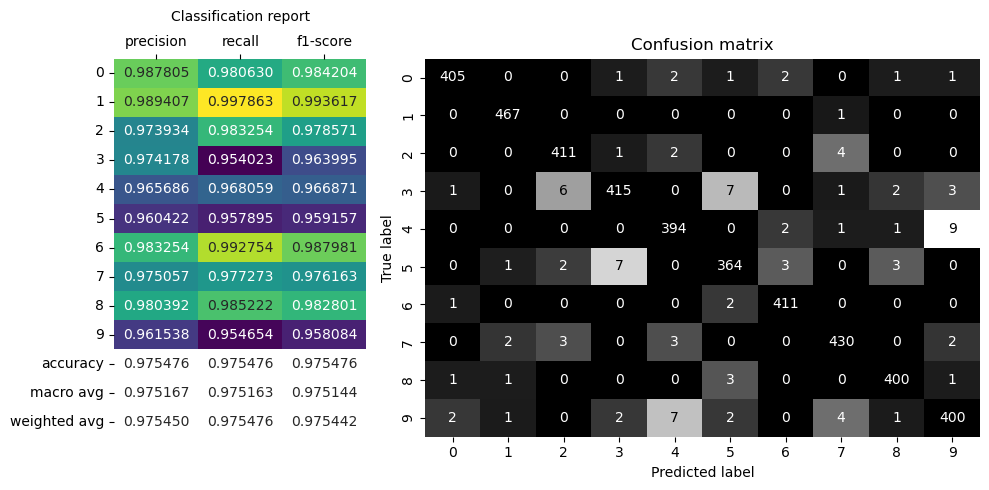

In [213]:
pipeline_scaler = Pipeline([
    ('pca', PCA(n_components=75)),
    ('scaler', None),
    ('model', SVC()),
])
params_scaler = [
    {
        'scaler': [MinMaxScaler(), StandardScaler(), Binarizer(threshold=50)]
    }
]
grid_search_scaler = GridSearchCV(pipeline_scaler, params_scaler, cv=3, 
                                  scoring='accuracy', n_jobs=-1, verbose=verbose_tuning)
grid_search_scaler.fit(X_train[:20000], y_train[:20000])
GridSearchReport(grid_search_scaler).display_report()
report_scaler = EstimatorReport(grid_search_scaler, X_val, y_val, [], [], "SVC (with PCA and scaler)")
report_scaler.display_report()

We see that the MinMaxScaler is the best one (with SVC classifier).

### Estimate Deskew <a class="anchor" id="estimatedeskew"></a>

### <span style="color: black;">Evaluation on the Validation Set (estimator: SVC (PCA, Scaler, no deskew))</span>

Accuracy: 98.0000%

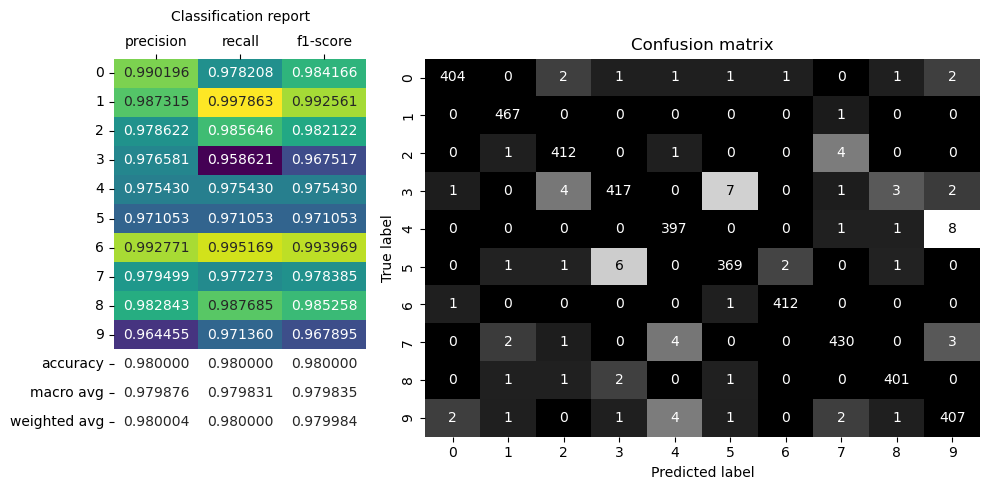

In [147]:
pipe_no_deskewed = copy.copy(full_pipeline).set_params(model=SVC())
pipe_no_deskewed.fit(X_train, y_train)
report_nodes = EstimatorReport(pipe_no_deskewed, X_val, y_val, [], [], "SVC (PCA, Scaler, no deskew)")
report_nodes.display_report()

### <span style="color: black;">Evaluation on the Validation Set (estimator: SVC (PCA, Scaler, deskew))</span>

Accuracy: 98.5476%

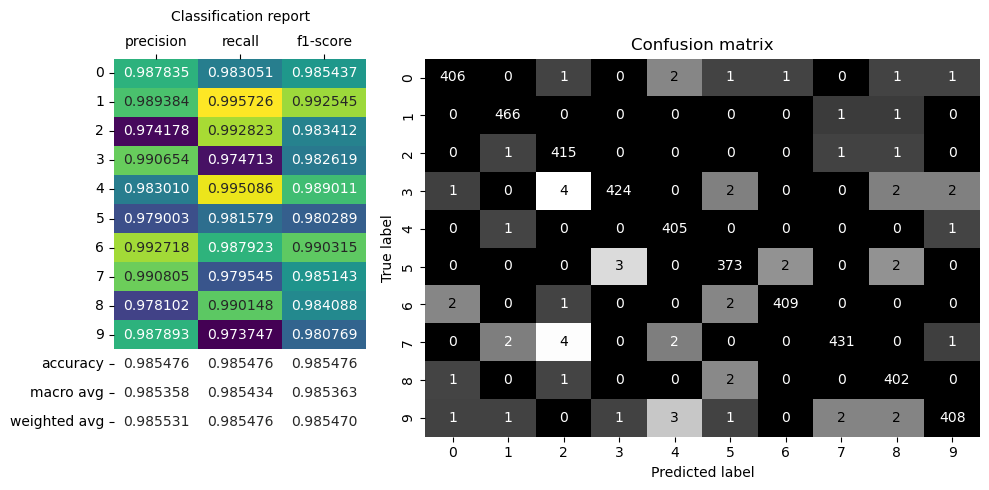

In [148]:
pipe_deskewed = copy.copy(full_pipeline).set_params(model=SVC())
pipe_deskewed.fit(X_train_deskewed, y_train)
report_des = EstimatorReport(pipe_deskewed, X_val_deskewed, y_val, [], [], "SVC (PCA, Scaler, deskew)")
report_des.display_report()

The model performance with deskewed data is better, so we will continue to use it.

### Estimate different models (default params) <a class="anchor" id="estimatedifferentmodels"></a>

Estimate different models using default hyperparams.

In [149]:
params = [
    {'model': [
        SGDClassifier(max_iter=4000),
        LogisticRegression(max_iter=8000),
        SVC(),
        KNeighborsClassifier(),
        GaussianNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        ExtraTreesClassifier(),
        xgb.XGBClassifier(),
        GradientBoostingClassifier(n_estimators=20),
        HistGradientBoostingClassifier(),
        AdaBoostClassifier(),
        BaggingClassifier(),
    ]}]
grid_search_allmodels = GridSearchCV(full_pipeline, params, cv=3, 
                                     scoring=['accuracy', 'f1_macro'], n_jobs=1, 
                                     verbose=10, refit=False)
grid_search_allmodels.fit(X_train_deskewed, y_train)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV 1/3; 1/13] START model=SGDClassifier(max_iter=4000).........................
[CV 1/3; 1/13] END model=SGDClassifier(max_iter=4000); accuracy: (test=0.941) f1_macro: (test=0.940) total time=   2.9s
[CV 2/3; 1/13] START model=SGDClassifier(max_iter=4000).........................
[CV 2/3; 1/13] END model=SGDClassifier(max_iter=4000); accuracy: (test=0.940) f1_macro: (test=0.940) total time=   2.8s
[CV 3/3; 1/13] START model=SGDClassifier(max_iter=4000).........................
[CV 3/3; 1/13] END model=SGDClassifier(max_iter=4000); accuracy: (test=0.941) f1_macro: (test=0.940) total time=   2.7s
[CV 1/3; 2/13] START model=LogisticRegression(max_iter=8000)....................
[CV 1/3; 2/13] END model=LogisticRegression(max_iter=8000); accuracy: (test=0.954) f1_macro: (test=0.954) total time=   5.6s
[CV 2/3; 2/13] START model=LogisticRegression(max_iter=8000)....................
[CV 2/3; 2/13] END model=LogisticRegression(max_i

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         MinMaxScaler()),
                                                        ('pca',
                                                         PCA(n_components=75))])),
                                       ('model', None)]),
             n_jobs=1,
             param_grid=[{'model': [SGDClassifier(max_iter=4000),
                                    LogisticRegression(max_iter=8000), SVC(),
                                    KNeighborsClassifier(), GaussianNB(),
                                    DecisionTreeClassifier(),
                                    RandomForestClassifier(),
                                    ExtraTreesCla...
                                                  min_child_weight=None,
                                                  missing=nan,
                         

In [194]:
report_gridsearch_all = GridSearchReport(grid_search_allmodels)
report_gridsearch_all.display_report(sortby='mean_test_accuracy', ascending=False)
display(report_gridsearch_all.get_summary(columns=['mean_fit_time'], sortby='mean_test_accuracy'))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
0,6.447755,0.051978,5.896950,0.042561,SVC(),{'model': SVC()},0.985238,0.985317,0.983492,0.984683,0.000842,1,0.985200,0.985152,0.983455,0.984602,0.000812,1
1,1.619056,0.024108,5.532190,0.109236,KNeighborsClassifier(),{'model': KNeighborsClassifier()},0.982302,0.981032,0.980794,0.981376,0.000662,2,0.982225,0.980726,0.980687,0.981213,0.000716,2
2,12.382998,0.283389,0.617296,0.018487,HistGradientBoostingClassifier(),{'model': HistGradientBoostingClassifier()},0.975238,0.971508,0.970159,0.972302,0.002148,3,0.975084,0.971148,0.969871,0.972034,0.002219,3
3,97.577698,1.198053,0.260363,0.011295,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.972540,0.970714,0.966349,0.969868,0.002597,4,0.972384,0.970330,0.965934,0.969549,0.002690,4
4,6.370699,0.039197,0.397897,0.004184,ExtraTreesClassifier(),{'model': ExtraTreesClassifier()},0.972619,0.967063,0.966508,0.968730,0.002759,5,0.972489,0.966621,0.966289,0.968467,0.002848,5


,mean_test_accuracy,mean_test_f1_macro,mean_fit_time
model,,,
SVC,0.984683,0.984602,6.447755
KNeighborsClassifier,0.981376,0.981213,1.619056
HistGradientBoostingClassifier,0.972302,0.972034,12.382998
XGBClassifier,0.969868,0.969549,97.577698
ExtraTreesClassifier,0.968730,0.968467,6.370699
RandomForestClassifier,0.965159,0.964816,23.093502
LogisticRegression,0.952354,0.951809,5.752519
SGDClassifier,0.940714,0.940126,2.686585
BaggingClassifier,0.927804,0.926810,26.958281


The best classifier with default parameters is SVC, the fastest are KNeighborsClassifier and GaussianNB.

### Fine-Tuning <a class="anchor" id="finetuning"></a>

Below I use different tools for hyperparameteres search like GridSearcCV, HalvingGridSearchCV, BayesSearchCV. It depends on fitting speed, search complexity.

#### SVC <a class="anchor" id="finetuningsvc"></a>

I also tested the poly kernel, but it showed poor performance, so I removed it from the final evaluation.

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 466
max_resources_: 37800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 120
n_resources: 466
Fitting 3 folds for each of 120 candidates, totalling 360 fits
----------
iter: 1
n_candidates: 40
n_resources: 1398
Fitting 3 folds for each of 40 candidates, totalling 120 fits
----------
iter: 2
n_candidates: 14
n_resources: 4194
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 3
n_candidates: 5
n_resources: 12582
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 2
n_resources: 37746
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__gamma,param_model__kernel,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,466,0.102186,0.001413,0.008654,0.000371,"SVC(C=5, gamma=0.022000000000000002, probabili...",3,0.001,rbf,...,0.825806,0.806452,0.838710,0.032897,181,0.909677,0.887097,0.945161,0.913978,0.023899
1,0,466,0.096226,0.001314,0.008193,0.000095,"SVC(C=5, gamma=0.022000000000000002, probabili...",4,0.001,rbf,...,0.845161,0.832258,0.864516,0.036874,179,0.919355,0.929032,0.951613,0.933333,0.013516
2,0,466,0.095793,0.000772,0.007907,0.000270,"SVC(C=5, gamma=0.022000000000000002, probabili...",5,0.001,rbf,...,0.858065,0.832258,0.864516,0.029329,179,0.935484,0.948387,0.954839,0.946237,0.008047
3,0,466,0.094376,0.000892,0.007835,0.000152,"SVC(C=5, gamma=0.022000000000000002, probabili...",6,0.001,rbf,...,0.864516,0.838710,0.877419,0.037986,178,0.945161,0.954839,0.961290,0.953763,0.006628
4,0,466,0.098831,0.001731,0.007905,0.000210,"SVC(C=5, gamma=0.022000000000000002, probabili...",7,0.001,rbf,...,0.864516,0.851613,0.879570,0.030866,177,0.948387,0.961290,0.964516,0.958065,0.006969


Best Results:


{'model': SVC(C=5, gamma=0.022000000000000002, probability=True),
 'model__C': 5,
 'model__gamma': 0.022000000000000002,
 'model__kernel': 'rbf',
 'model__probability': True}

### <span style="color: black;">Evaluation on the Validation Set (estimator: SVC)</span>

Accuracy: 98.8333%

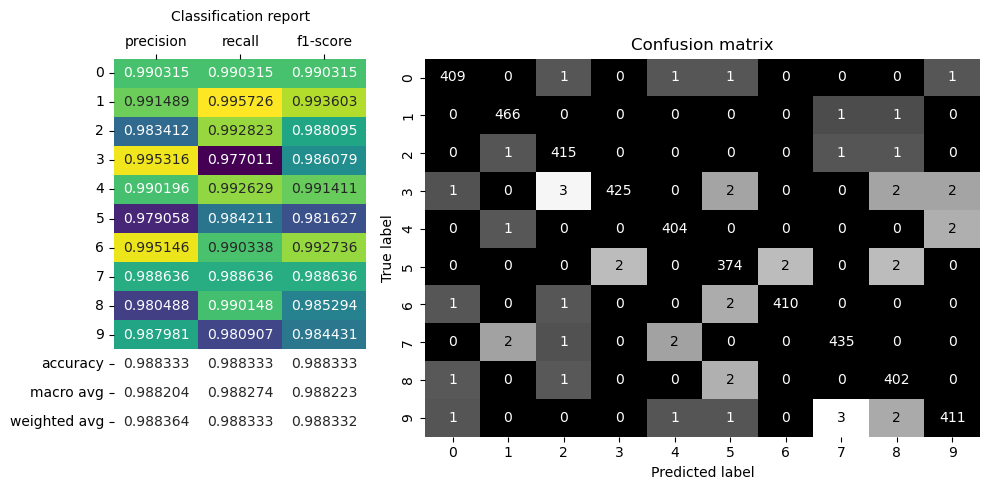

In [151]:
params_svc = [
    {
        'model': [SVC()],
        'model__kernel': ['rbf'],
        'model__C': np.arange(3, 15, 1),
        'model__gamma': np.arange(0.001, 0.03, 0.003),
        'model__probability': [True],
    }
]
grid_search_svc = HalvingGridSearchCV(full_pipeline, params_svc, cv=3, 
                                      scoring='accuracy', verbose=verbose_tuning, 
                                      n_jobs=-1)
grid_search_svc.fit(X_train_deskewed, y_train)
best_svc = grid_search_svc.best_estimator_
GridSearchReport(grid_search_svc).display_report()
report_svc = EstimatorReport(best_svc, X_val_deskewed, y_val, [], [], "SVC")
report_svc.display_report()
results_df = add_to_results(report_svc, results_df)

We see that the tuning also slightly increased the metrics.

### Errors visualization

Let's look at some errors after fine-tuning the SVC classifier.

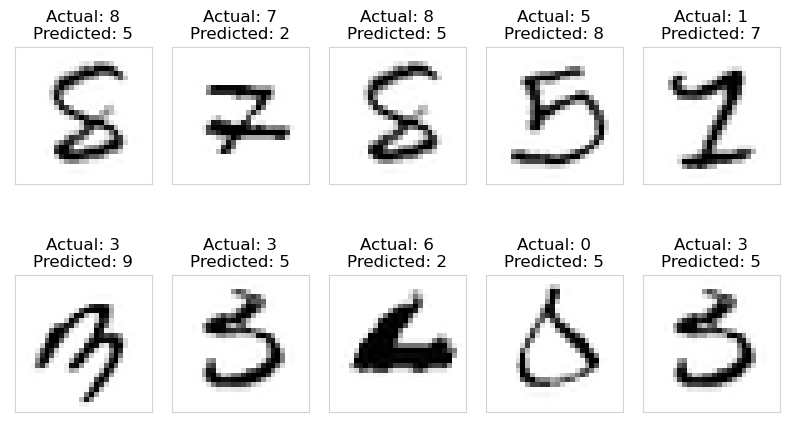

In [152]:
plot_errors(best_svc, X_val_deskewed, y_val, 10, 5)

#### LogisticRegression <a class="anchor" id="finetuninglr"></a>

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4200
max_resources_: 37800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 4200
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 6
n_resources: 12600
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 2
n_resources: 37800
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__max_iter,param_model__solver,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,4200,0.897849,0.047460,0.018358,0.004399,"LogisticRegression(C=0.20000000000000004, max_...",0.9,6000,lbfgs,...,0.923571,0.940714,0.935000,0.008081,26,0.978214,0.980714,0.982143,0.980357,0.001624
1,0,4200,0.756712,0.032375,0.018227,0.001378,"LogisticRegression(C=0.20000000000000004, max_...",0.65,6000,lbfgs,...,0.923571,0.942143,0.935238,0.008296,25,0.976071,0.978571,0.978929,0.977857,0.001271
2,0,4200,0.624698,0.125644,0.012549,0.003295,"LogisticRegression(C=0.20000000000000004, max_...",0.95,6000,lbfgs,...,0.922143,0.944286,0.935952,0.009834,21,0.978929,0.980357,0.983214,0.980833,0.001782
3,0,4200,0.815687,0.049446,0.020484,0.005011,"LogisticRegression(C=0.20000000000000004, max_...",0.85,6000,lbfgs,...,0.923571,0.944286,0.935952,0.008928,21,0.977857,0.980000,0.982143,0.980000,0.001750
4,0,4200,0.822521,0.018377,0.020703,0.004683,"LogisticRegression(C=0.20000000000000004, max_...",0.5,6000,lbfgs,...,0.927143,0.942143,0.935952,0.006398,21,0.974643,0.975357,0.977857,0.975952,0.001378


Best Results:


{'model': LogisticRegression(C=0.20000000000000004, max_iter=6000),
 'model__C': 0.20000000000000004,
 'model__max_iter': 6000,
 'model__solver': 'lbfgs'}

### <span style="color: black;">Evaluation on the Validation Set (estimator: LogisticRegression)</span>

Accuracy: 95.1429%

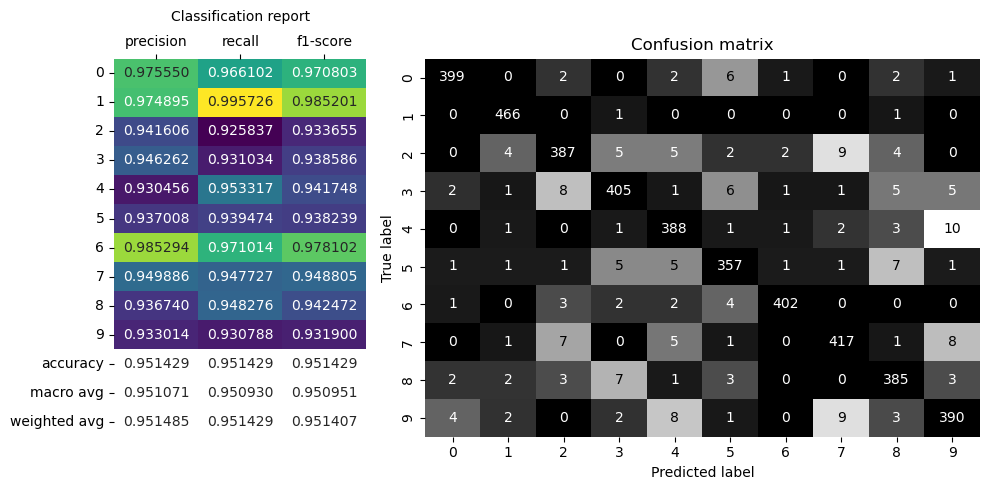

In [153]:
params_lr = [
    {
        'model': [LogisticRegression()],
        'model__solver': ['lbfgs'],
        'model__C': np.arange(0.1, 1, 0.05),
        'model__max_iter': [6000],
    },
]
grid_search_lr = HalvingGridSearchCV(full_pipeline, params_lr, cv=3, 
                                     scoring='accuracy', verbose=verbose_tuning, n_jobs=-1)
grid_search_lr.fit(X_train_deskewed, y_train)
best_lr = grid_search_lr.best_estimator_
GridSearchReport(grid_search_lr).display_report()
report_lr = EstimatorReport(best_lr, X_val_deskewed, y_val, [], [], "LogisticRegression")
report_lr.display_report()
results_df = add_to_results(report_lr, results_df)

#### RandomForestClassifier <a class="anchor" id="finetuningrf"></a>

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4200
max_resources_: 37800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 14
n_resources: 4200
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 1
n_candidates: 5
n_resources: 12600
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


----------
iter: 2
n_candidates: 2
n_resources: 37800
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__min_samples_leaf,param_model__n_estimators,param_model__n_jobs,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,4200,3.656050,0.297759,0.171860,0.013736,"RandomForestClassifier(min_samples_leaf=2, n_e...",3,150,-1,...,0.943571,0.940000,0.938095,0.005419,21,0.998929,0.998571,0.998929,0.998810,0.000168
1,0,4200,4.705208,0.297944,0.258341,0.005360,"RandomForestClassifier(min_samples_leaf=2, n_e...",3,250,-1,...,0.940000,0.934286,0.939286,0.003824,20,0.998571,0.998571,0.999643,0.998929,0.000505
2,0,4200,6.431939,0.157124,0.259533,0.008156,"RandomForestClassifier(min_samples_leaf=2, n_e...",3,350,-1,...,0.945000,0.938571,0.942143,0.002673,19,0.998571,0.998929,0.999643,0.999048,0.000445
3,0,4200,12.060050,0.533882,0.350065,0.023143,"RandomForestClassifier(min_samples_leaf=2, n_e...",3,650,-1,...,0.943571,0.940000,0.942619,0.001875,18,0.999286,0.998929,0.999643,0.999286,0.000292
4,0,4200,8.404643,0.238157,0.281338,0.008182,"RandomForestClassifier(min_samples_leaf=2, n_e...",3,450,-1,...,0.945000,0.940714,0.943095,0.001782,17,0.998929,0.998929,0.999643,0.999167,0.000337


Best Results:


{'model': RandomForestClassifier(min_samples_leaf=2, n_estimators=650, n_jobs=-1),
 'model__min_samples_leaf': 2,
 'model__n_estimators': 650,
 'model__n_jobs': -1}

### <span style="color: black;">Evaluation on the Validation Set (estimator: RandomForestClassifier)</span>

Accuracy: 97.4048%

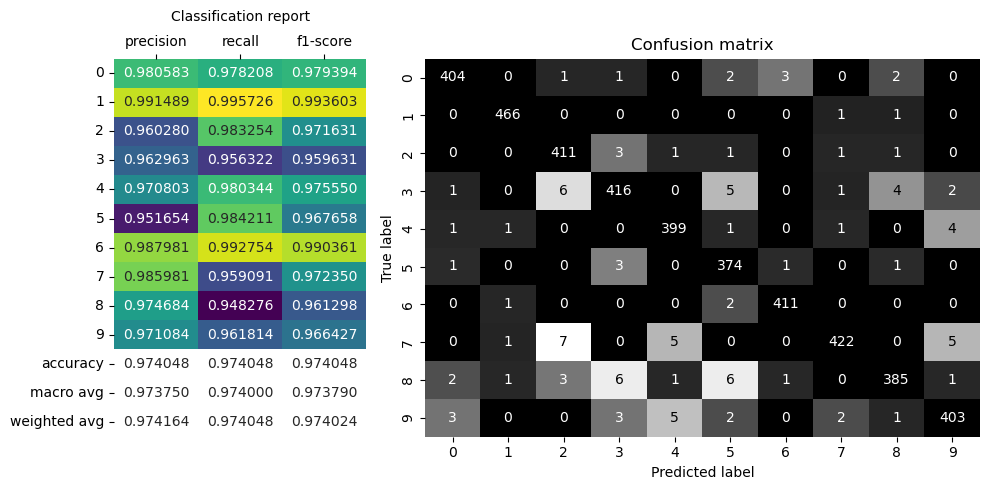

In [154]:
params_rf = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': np.arange(150, 800, 100),
        'model__min_samples_leaf': [2, 3],
        'model__n_jobs': [-1],
    }
]
grid_search_rf = HalvingGridSearchCV(full_pipeline, params_rf, cv=3, 
                                     scoring='accuracy', verbose=verbose_tuning, 
                                     n_jobs=-1)
grid_search_rf.fit(X_train_deskewed, y_train)
best_rf = grid_search_rf.best_estimator_
GridSearchReport(grid_search_rf).display_report()
report_rf = EstimatorReport(best_rf, X_val_deskewed, y_val, [], [], "RandomForestClassifier")
report_rf.display_report()
results_df = add_to_results(report_rf, results_df)

#### ExtraTreesClassifier <a class="anchor" id="finetuninget"></a>

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4200
max_resources_: 37800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 4200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 4
n_resources: 12600
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


----------
iter: 2
n_candidates: 2
n_resources: 37800
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__min_samples_leaf,param_model__n_estimators,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,4200,1.724830,0.001007,0.113842,0.001595,"ExtraTreesClassifier(min_samples_leaf=2, n_est...",4,250,{'model': ExtraTreesClassifier(min_samples_lea...,...,0.940000,0.937857,0.938333,0.001214,17,0.999643,0.998214,1.0,0.999286,0.000772
1,0,4200,1.240066,0.039578,0.077225,0.005817,"ExtraTreesClassifier(min_samples_leaf=2, n_est...",3,150,{'model': ExtraTreesClassifier(min_samples_lea...,...,0.942143,0.936429,0.938333,0.002694,17,1.000000,0.999643,1.0,0.999881,0.000168
2,0,4200,1.169039,0.017385,0.074759,0.001808,"ExtraTreesClassifier(min_samples_leaf=2, n_est...",4,150,{'model': ExtraTreesClassifier(min_samples_lea...,...,0.941429,0.931429,0.938810,0.005292,16,0.999643,0.998214,1.0,0.999286,0.000772
3,0,4200,2.528159,0.116385,0.150199,0.002046,"ExtraTreesClassifier(min_samples_leaf=2, n_est...",4,450,{'model': ExtraTreesClassifier(min_samples_lea...,...,0.947143,0.939286,0.943095,0.003212,15,1.000000,0.997857,1.0,0.999286,0.001010
4,0,4200,2.452995,0.135815,0.160087,0.001148,"ExtraTreesClassifier(min_samples_leaf=2, n_est...",3,350,{'model': ExtraTreesClassifier(min_samples_lea...,...,0.945000,0.940714,0.943810,0.002208,14,1.000000,0.999286,1.0,0.999762,0.000337


Best Results:


{'model': ExtraTreesClassifier(min_samples_leaf=2, n_estimators=450),
 'model__min_samples_leaf': 2,
 'model__n_estimators': 450}

### <span style="color: black;">Evaluation on the Validation Set (estimator: ExtraTreesClassifier)</span>

Accuracy: 97.4286%

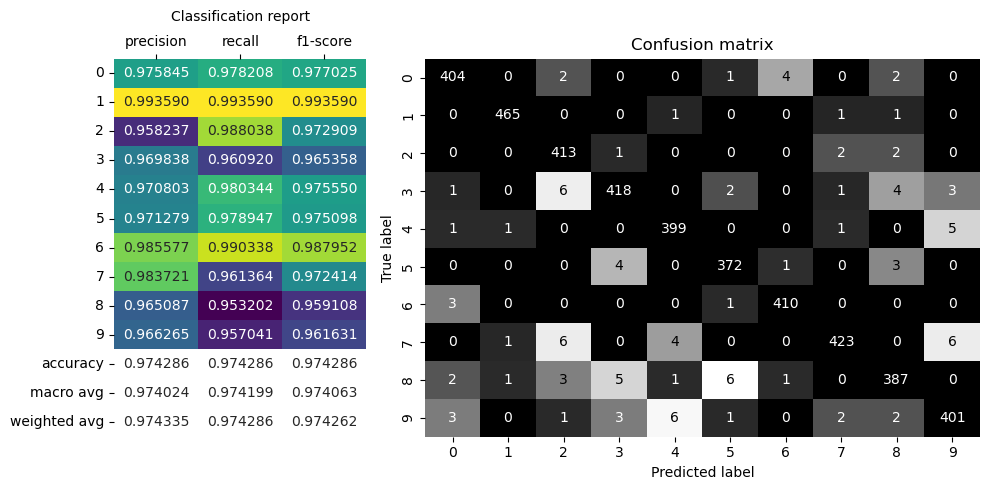

In [155]:
params_et = [
    {
        'model': [ExtraTreesClassifier()],
        'model__n_estimators': np.arange(150, 550, 100),
        'model__min_samples_leaf': np.arange(2, 5, 1),
#         'model__n_jobs': [-1],
    }
]
grid_search_et = HalvingGridSearchCV(full_pipeline, params_et, cv=3, 
                                     scoring='accuracy', verbose=verbose_tuning, 
                                     n_jobs=-1)
grid_search_et.fit(X_train_deskewed, y_train)
best_et = grid_search_et.best_estimator_
GridSearchReport(grid_search_et).display_report()
report_et = EstimatorReport(best_et, X_val_deskewed, y_val, [], [], "ExtraTreesClassifier")
report_et.display_report()
results_df = add_to_results(report_et, results_df)

#### KNeighborsClassifier <a class="anchor" id="finetuningknn"></a>

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 12600
max_resources_: 37800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 12600
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 2
n_resources: 37800
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__n_jobs,param_model__n_neighbors,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,12600,1.442652,0.216709,1.070420,0.262842,KNeighborsClassifier(n_jobs=-1),-1,17,"{'model': KNeighborsClassifier(n_jobs=-1), 'mo...",...,0.965000,0.969762,0.966508,0.002303,8,0.967381,0.970000,0.965595,0.967659,0.001809
1,0,12600,1.266127,0.265276,1.429897,0.252604,KNeighborsClassifier(n_jobs=-1),-1,14,"{'model': KNeighborsClassifier(n_jobs=-1), 'mo...",...,0.966190,0.970000,0.967937,0.001571,7,0.970119,0.971667,0.969881,0.970556,0.000792
2,0,12600,1.296252,0.078414,1.341251,0.085757,KNeighborsClassifier(n_jobs=-1),-1,11,"{'model': KNeighborsClassifier(n_jobs=-1), 'mo...",...,0.968333,0.971190,0.969762,0.001166,6,0.972143,0.974048,0.971310,0.972500,0.001146
3,0,12600,1.306098,0.217058,1.317852,0.069827,KNeighborsClassifier(n_jobs=-1),-1,8,"{'model': KNeighborsClassifier(n_jobs=-1), 'mo...",...,0.968810,0.972857,0.971508,0.001908,5,0.976190,0.975952,0.975714,0.975952,0.000194
4,0,12600,1.334354,0.025156,1.212254,0.107746,KNeighborsClassifier(n_jobs=-1),-1,2,"{'model': KNeighborsClassifier(n_jobs=-1), 'mo...",...,0.970952,0.974048,0.972063,0.001406,4,0.986905,0.985833,0.986310,0.986349,0.000438


Best Results:


{'model': KNeighborsClassifier(n_jobs=-1),
 'model__n_jobs': -1,
 'model__n_neighbors': 5}

### <span style="color: black;">Evaluation on the Validation Set (estimator: KNeighborsClassifier)</span>

Accuracy: 98.5238%

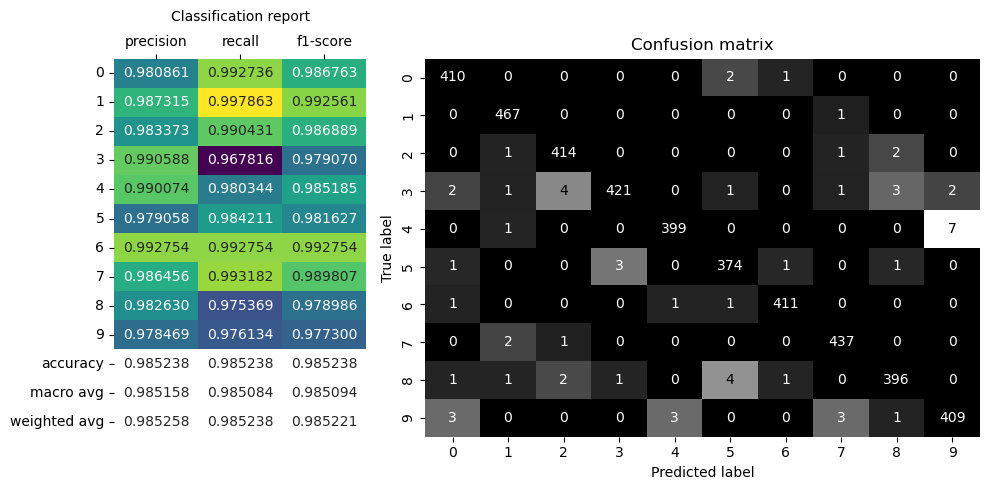

In [156]:
params_knn = [
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': np.arange(2, 20, 3),
        'model__n_jobs': [-1],
    }
]
grid_search_knn = HalvingGridSearchCV(full_pipeline, params_knn, cv=3, 
                                      scoring='accuracy', verbose=verbose_tuning, 
                                      n_jobs=-1)
grid_search_knn.fit(X_train_deskewed, y_train)
best_knn = grid_search_knn.best_estimator_
GridSearchReport(grid_search_knn).display_report()
report_knn = EstimatorReport(best_knn, X_val_deskewed, y_val, [], [], "KNeighborsClassifier")
report_knn.display_report()
results_df = add_to_results(report_knn, results_df)

#### HistGradientBoostingClassifier <a class="anchor" id="finetuninghb"></a>

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__learning_rate,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,rank_train_score
0,4.251504,0.336439,0.298345,0.008687,HistGradientBoostingClassifier(learning_rate=0...,0.235449,3,{'model': HistGradientBoostingClassifier(learn...,0.923016,0.920476,0.933730,0.925741,0.005744,12,0.980079,0.971111,0.987024,0.979405,0.006514,12
1,4.251878,0.194454,0.495356,0.268459,HistGradientBoostingClassifier(learning_rate=0...,0.230493,2,{'model': HistGradientBoostingClassifier(learn...,0.936746,0.922778,0.952143,0.937222,0.011993,11,0.980516,0.970317,0.996190,0.982341,0.010641,10
2,5.574239,1.781619,0.342014,0.057442,HistGradientBoostingClassifier(learning_rate=0...,0.221996,5,{'model': HistGradientBoostingClassifier(learn...,0.921111,0.970397,0.921667,0.937725,0.023104,10,0.968095,0.997262,0.977976,0.981111,0.012112,11
3,6.637998,1.392213,0.384999,0.058734,HistGradientBoostingClassifier(learning_rate=0...,0.230802,7,{'model': HistGradientBoostingClassifier(learn...,0.973016,0.972143,0.901349,0.948836,0.033580,9,0.996667,0.997024,0.961865,0.985185,0.016490,9
4,12.490581,0.347241,0.630217,0.007448,HistGradientBoostingClassifier(learning_rate=0...,0.051249,9,{'model': HistGradientBoostingClassifier(learn...,0.968571,0.965476,0.962381,0.965476,0.002527,8,0.996190,0.996905,0.995913,0.996336,0.000418,8


Best Results:


OrderedDict([('model',
              HistGradientBoostingClassifier(learning_rate=0.16062304519486406,
                                             min_samples_leaf=7)),
             ('model__learning_rate', 0.16062304519486406),
             ('model__min_samples_leaf', 7)])

### <span style="color: black;">Evaluation on the Validation Set (estimator: HistGradientBoostingClassifier)</span>

Accuracy: 97.7381%

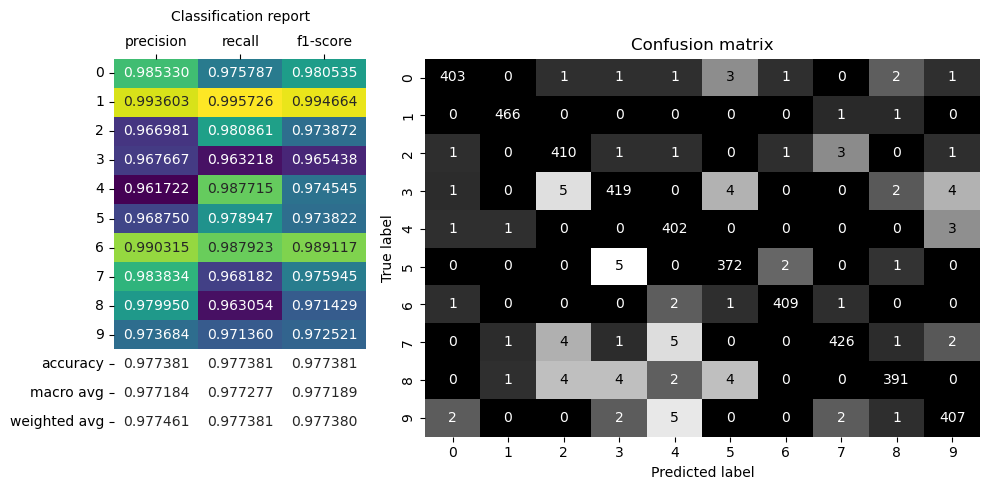

In [157]:
params_hb = [
    {
        'model': [HistGradientBoostingClassifier()],
        'model__learning_rate': space.Real(0.01, 0.25),
        'model__min_samples_leaf': space.Integer(1, 14),
    }
]
bayes_search_hb = BayesSearchCV(full_pipeline, params_hb, cv=3, n_iter = 12, 
                                scoring='accuracy', refit=True, verbose=verbose_tuning, n_points = 1, 
                                return_train_score=True, random_state=42)
bayes_search_hb.fit(X_train_deskewed, y_train)
best_hb = bayes_search_hb.best_estimator_
GridSearchReport(bayes_search_hb).display_report()
report_hb = EstimatorReport(best_hb, X_val_deskewed, y_val, [], [], "HistGradientBoostingClassifier")
report_hb.display_report()
results_df = add_to_results(report_hb, results_df)

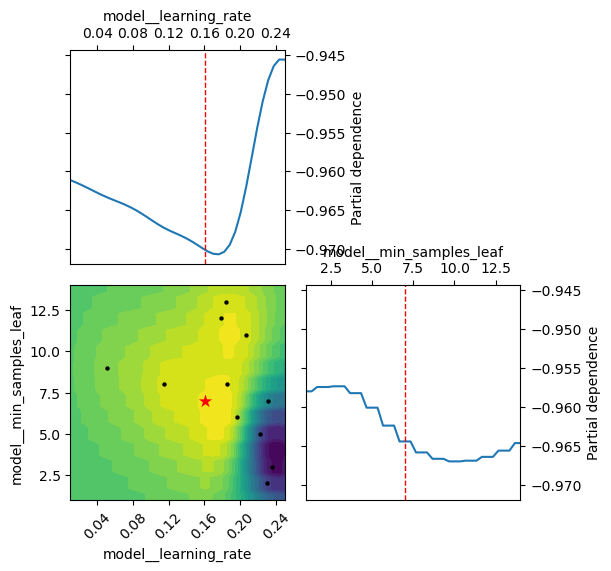

In [158]:
plots.plot_objective(bayes_search_hb.optimizer_results_[0],
                     size = 2.5, levels = 25)
plt.show()

#### AdaBoostClassifier (base: HistGradientBoostingClassifier) <a class="anchor" id="finetuningadbhb"></a>

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1400
max_resources_: 37800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 1400
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 11
n_resources: 4200
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 2
n_candidates: 4
n_resources: 12600
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 37800
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__base_estimator,param_model__learning_rate,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,1400,2.209246,0.009555,0.041126,0.000969,AdaBoostClassifier(base_estimator=HistGradient...,SAMME.R,HistGradientBoostingClassifier(learning_rate=0...,0.2,...,0.879828,0.873391,0.885551,0.012915,49,1.0,1.0,1.0,1.0,0.0
1,0,1400,2.147900,0.053428,0.053156,0.020183,AdaBoostClassifier(base_estimator=HistGradient...,SAMME.R,HistGradientBoostingClassifier(learning_rate=0...,0.8,...,0.881974,0.881974,0.887697,0.008093,47,1.0,1.0,1.0,1.0,0.0
2,0,1400,2.125380,0.079982,0.044574,0.005391,AdaBoostClassifier(base_estimator=HistGradient...,SAMME.R,HistGradientBoostingClassifier(learning_rate=0...,0.4,...,0.881974,0.875536,0.887697,0.012915,47,1.0,1.0,1.0,1.0,0.0
3,0,1400,2.373411,0.118028,0.048589,0.008424,AdaBoostClassifier(base_estimator=HistGradient...,SAMME.R,HistGradientBoostingClassifier(learning_rate=0...,0.1,...,0.879828,0.877682,0.887697,0.012675,45,1.0,1.0,1.0,1.0,0.0
4,0,1400,2.102296,0.061978,0.041218,0.001532,AdaBoostClassifier(base_estimator=HistGradient...,SAMME.R,HistGradientBoostingClassifier(learning_rate=0...,0.2,...,0.879828,0.873391,0.887697,0.015899,45,1.0,1.0,1.0,1.0,0.0


Best Results:


{'model': AdaBoostClassifier(base_estimator=HistGradientBoostingClassifier(learning_rate=0.16062304519486406,
                                                                  min_samples_leaf=7),
                    learning_rate=0.5, n_estimators=25),
 'model__algorithm': 'SAMME.R',
 'model__base_estimator': HistGradientBoostingClassifier(learning_rate=0.16062304519486406,
                                min_samples_leaf=7),
 'model__learning_rate': 0.5,
 'model__n_estimators': 25}

### <span style="color: black;">Evaluation on the Validation Set (estimator: AdaBoostClassifier (HistGB))</span>

Accuracy: 98.0952%

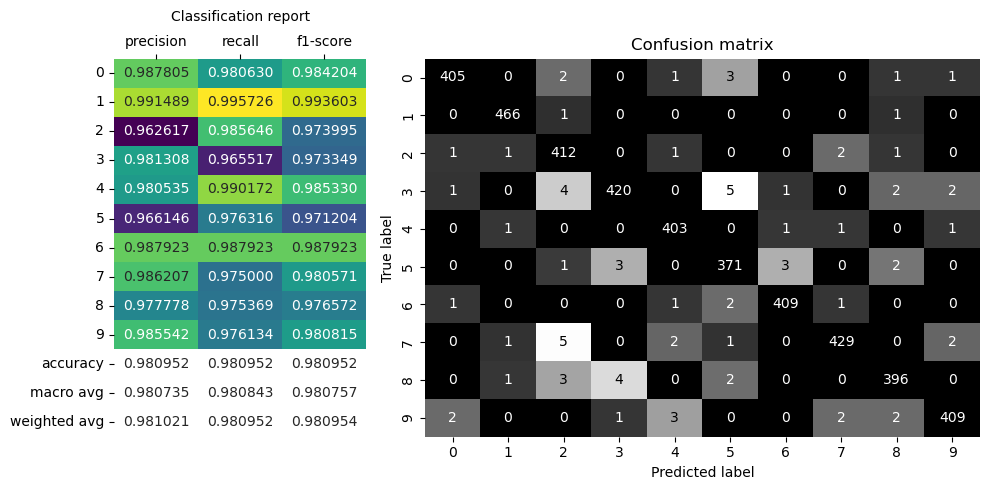

In [159]:
params_adb_hb = [
    {
        'model': [AdaBoostClassifier()],
        'model__base_estimator': [best_hb['model']],
        'model__n_estimators': np.arange(5, 40, 10),
        'model__learning_rate': np.arange(0.1, 0.9, 0.1),
        'model__algorithm': ['SAMME.R'],
    }
]
grid_search_adb_hb = HalvingGridSearchCV(full_pipeline, params_adb_hb, cv=3, 
                                     scoring='accuracy', verbose=verbose_tuning, 
                                     n_jobs=-1)
grid_search_adb_hb.fit(X_train_deskewed, y_train)
best_adb_hb = grid_search_adb_hb.best_estimator_
GridSearchReport(grid_search_adb_hb).display_report()
report_adb_hb = EstimatorReport(best_adb_hb, X_val_deskewed, y_val, [], [], "AdaBoostClassifier (HistGB)")
report_adb_hb.display_report()
results_df = add_to_results(report_adb_hb, results_df)

#### AdaBoostClassifier (base: ExtraTreesClassifier) <a class="anchor" id="finetuningadbet"></a>

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 12600
max_resources_: 37800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 12600
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


----------
iter: 1
n_candidates: 2
n_resources: 37800
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__base_estimator,param_model__learning_rate,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,12600,11.116061,0.149416,0.618637,0.028758,AdaBoostClassifier(base_estimator=ExtraTreesCl...,SAMME.R,"(ExtraTreeClassifier(min_samples_leaf=2, rando...",0.2,...,0.968095,0.960000,0.963095,0.003569,6,1.0,1.0,1.0,1.0,0.0
1,0,12600,11.877963,0.411884,0.595464,0.023106,AdaBoostClassifier(base_estimator=ExtraTreesCl...,SAMME.R,"(ExtraTreeClassifier(min_samples_leaf=2, rando...",0.02,...,0.967143,0.962619,0.964048,0.002191,5,1.0,1.0,1.0,1.0,0.0
2,0,12600,10.905055,0.057224,0.677024,0.134272,AdaBoostClassifier(base_estimator=ExtraTreesCl...,SAMME.R,"(ExtraTreeClassifier(min_samples_leaf=2, rando...",0.2,...,0.968333,0.963095,0.964524,0.002722,4,1.0,1.0,1.0,1.0,0.0
3,0,12600,11.058332,0.210871,0.684825,0.149721,AdaBoostClassifier(base_estimator=ExtraTreesCl...,SAMME.R,"(ExtraTreeClassifier(min_samples_leaf=2, rando...",0.02,...,0.968095,0.964762,0.965000,0.002436,3,1.0,1.0,1.0,1.0,0.0
4,1,37800,31.566398,4.983412,1.532885,0.149972,AdaBoostClassifier(base_estimator=ExtraTreesCl...,SAMME.R,"(ExtraTreeClassifier(min_samples_leaf=2, rando...",0.02,...,0.967619,0.967857,0.969259,0.002153,2,1.0,1.0,1.0,1.0,0.0


Best Results:


{'model': AdaBoostClassifier(base_estimator=ExtraTreesClassifier(min_samples_leaf=2,
                                                        n_estimators=450),
                    learning_rate=0.2, n_estimators=20),
 'model__algorithm': 'SAMME.R',
 'model__base_estimator': ExtraTreesClassifier(min_samples_leaf=2, n_estimators=450),
 'model__learning_rate': 0.2,
 'model__n_estimators': 20}

### <span style="color: black;">Evaluation on the Validation Set (estimator: AdaBoostClassifier (ExtTr))</span>

Accuracy: 97.4524%

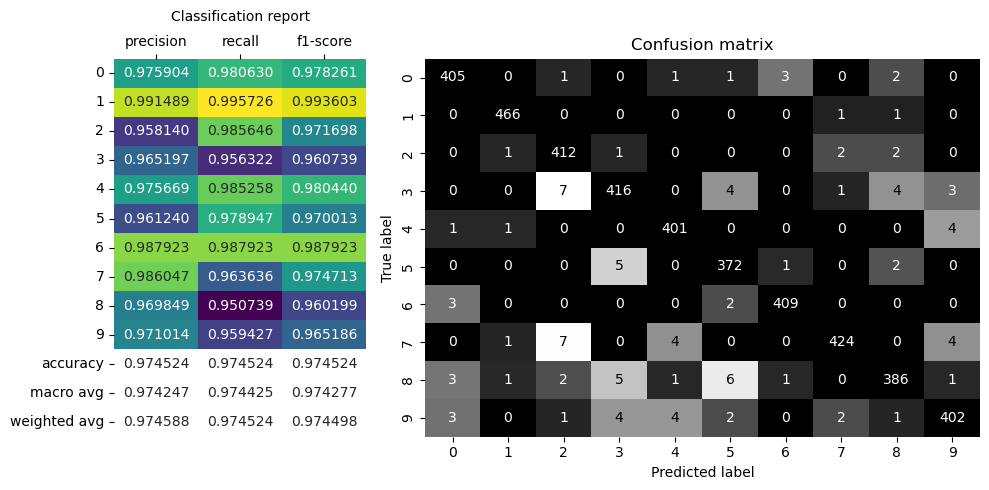

In [160]:
params_adb_et = [
    {
        'model': [AdaBoostClassifier()],
        'model__base_estimator': [best_et['model']],
        'model__n_estimators': [10, 20],
        'model__learning_rate': [0.02, 0.2],
        'model__algorithm': ['SAMME.R'],
    }
]
grid_search_adb_et = HalvingGridSearchCV(full_pipeline, params_adb_et, cv=3, 
                                        scoring='accuracy', verbose=verbose_tuning, 
                                        n_jobs=-1)
grid_search_adb_et.fit(X_train_deskewed, y_train)
best_adb_et = grid_search_adb_et.best_estimator_
GridSearchReport(grid_search_adb_et).display_report()
report_adb_et = EstimatorReport(best_adb_et, X_val_deskewed, y_val, [], [], "AdaBoostClassifier (ExtTr)")
report_adb_et.display_report()
results_df = add_to_results(report_adb_et, results_df)

#### AdaBoostClassifier (base: GaussianNB) <a class="anchor" id="finetuningadbgnb"></a>

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__base_estimator,param_model__learning_rate,param_model__n_estimators,params,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,rank_train_score
0,3.668968,0.042365,0.659893,0.021792,AdaBoostClassifier(base_estimator=GaussianNB()...,SAMME.R,GaussianNB(),0.41964,20,{'model': AdaBoostClassifier(base_estimator=Ga...,...,0.780635,0.777063,0.002652,10,0.781111,0.774048,0.781468,0.778876,0.003417,10
1,4.662668,0.044650,0.963495,0.013751,AdaBoostClassifier(base_estimator=GaussianNB()...,SAMME.R,GaussianNB(),0.402369,29,{'model': AdaBoostClassifier(base_estimator=Ga...,...,0.805079,0.812143,0.011247,9,0.811944,0.829127,0.811746,0.817606,0.008147,9
2,6.416419,0.281164,1.352947,0.009459,AdaBoostClassifier(base_estimator=GaussianNB()...,SAMME.R,GaussianNB(),0.475856,44,{'model': AdaBoostClassifier(base_estimator=Ga...,...,0.855794,0.818624,0.026470,8,0.798492,0.808968,0.866111,0.824524,0.029716,8
3,4.900243,0.003779,1.049612,0.022291,AdaBoostClassifier(base_estimator=GaussianNB()...,SAMME.R,GaussianNB(),0.437791,32,{'model': AdaBoostClassifier(base_estimator=Ga...,...,0.844286,0.840979,0.012437,7,0.859921,0.829325,0.850278,0.846508,0.012772,7
4,6.394180,0.036653,1.401040,0.019044,AdaBoostClassifier(base_estimator=GaussianNB()...,SAMME.R,GaussianNB(),0.359278,46,{'model': AdaBoostClassifier(base_estimator=Ga...,...,0.868175,0.864630,0.002644,6,0.869841,0.865913,0.873810,0.869854,0.003224,6


Best Results:


OrderedDict([('model',
              AdaBoostClassifier(base_estimator=GaussianNB(),
                                 learning_rate=0.09827051942388793, n_estimators=41)),
             ('model__algorithm', 'SAMME.R'),
             ('model__base_estimator', GaussianNB()),
             ('model__learning_rate', 0.09827051942388793),
             ('model__n_estimators', 41)])

### <span style="color: black;">Evaluation on the Validation Set (estimator: AdaBoostClassifier (GNB))</span>

Accuracy: 90.3095%

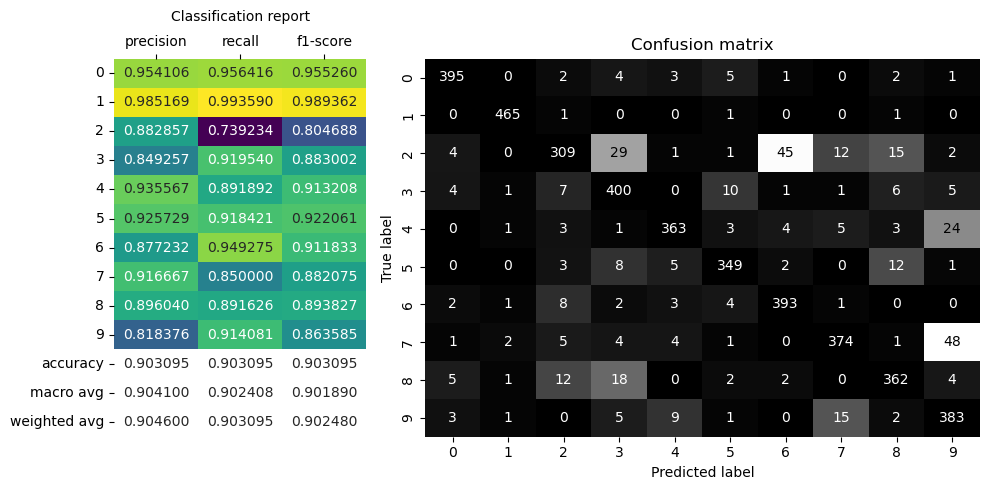

In [161]:
params_adb_gnb = [
    {
        'model': [AdaBoostClassifier()],
        'model__base_estimator': [GaussianNB()],
        'model__n_estimators': space.Integer(5, 50),
        'model__learning_rate': space.Real(0.005, 0.5),
        'model__algorithm': ['SAMME.R'],
    }
]
bayes_search_adb_gnb = BayesSearchCV(full_pipeline, params_adb_gnb, cv=3, n_iter = 10, 
                                     scoring='accuracy', refit=True, verbose=verbose_tuning, n_points = 1, 
                                     return_train_score=True, random_state=42)
bayes_search_adb_gnb.fit(X_train_deskewed, y_train)
best_adb_gnb = bayes_search_adb_gnb.best_estimator_
GridSearchReport(bayes_search_adb_gnb).display_report()
report_adb_gnb = EstimatorReport(best_adb_gnb, X_val_deskewed, y_val, [], [], "AdaBoostClassifier (GNB)")
report_adb_gnb.display_report()
results_df = add_to_results(report_adb_gnb, results_df)

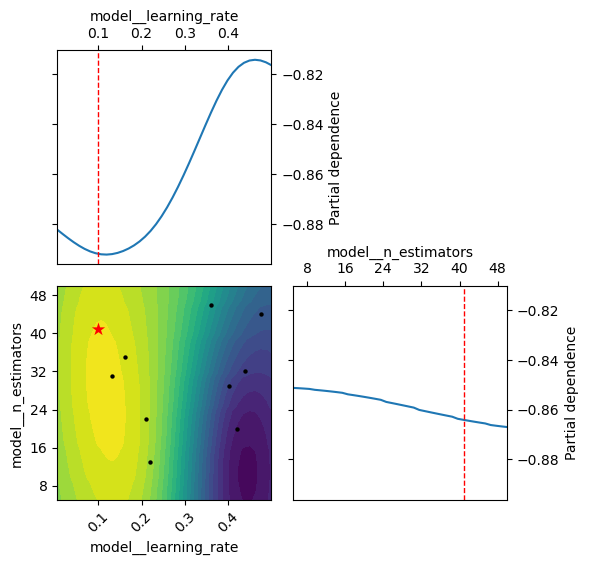

In [162]:
plots.plot_objective(bayes_search_adb_gnb.optimizer_results_[0],
                     size = 2.5, levels = 25)
plt.show()

### Estimations results <a class="anchor" id="estimationsresults"></a>

Compare the performance of models before and after tuning.

In [166]:
def display_merged_results(init_df, tuned_df):
    merged_df = pd.merge(init_df, tuned_df, on='model', how='outer')
    merged_df = merged_df.rename(columns={'accuracy_x': 'accuracy_init', 'accuracy_y': 'accuracy_tuned'})
    display(merged_df
            .sort_values(by='accuracy_tuned', ascending=False)
            .reset_index(drop=True)
            .style
            .background_gradient(cmap='viridis')
            .set_properties(**{'text-align': 'left'})
           )

In [167]:
report_alldefaults_df = (report_gridsearch_all
                         .get_summary(sortby='mean_test_accuracy')
                         .data
                         .reset_index()
                         .rename(columns={'mean_test_accuracy': 'accuracy'})
                         .drop(['mean_test_f1_macro'], axis=1)
                        )
display_merged_results(report_alldefaults_df, results_df)

,model,accuracy_init,accuracy_tuned
0,SVC,0.984683,0.988333
1,"SVC (PCA, Scaler, deskew)",nan,0.985476
2,KNeighborsClassifier,0.981376,0.985238
3,AdaBoostClassifier (HistGB),nan,0.980952
4,"SVC (PCA, Scaler, no deskew)",nan,0.980000
5,HistGradientBoostingClassifier,0.972302,0.977381
6,SVC (with PCA and scaler),nan,0.975476
7,AdaBoostClassifier (ExtTr),nan,0.974524
8,ExtraTreesClassifier,0.968730,0.974286
9,RandomForestClassifier,0.965159,0.974048


### Ensemble learning <a class="anchor" id="ensemblelearning"></a>

In [214]:
# Create models without fine-tuning
if True == False:
    print('Create models')
    best_svc = copy.copy(full_pipeline)
    best_svc.set_params(model=SVC(C=10, gamma=0.013, kernel='rbf', probability=True))

    best_rf = copy.copy(full_pipeline)
    best_rf.set_params(model=RandomForestClassifier(min_samples_leaf=2, n_estimators=550, n_jobs=-1))

    best_et = copy.copy(full_pipeline)
    best_et.set_params(model=ExtraTreesClassifier(min_samples_leaf=2, n_estimators=350))

    best_knn = copy.copy(full_pipeline)
    best_knn.set_params(model=KNeighborsClassifier(n_neighbors=5, n_jobs=-1))

    best_adb_et = copy.copy(full_pipeline)
    best_adb_et.set_params(model=AdaBoostClassifier(base_estimator=best_et['model'], n_estimators=20, 
                                      learning_rate=0.02, algorithm='SAMME.R'))

    best_hb = copy.copy(full_pipeline)
    best_hb.set_params(model=HistGradientBoostingClassifier(learning_rate=0.13, min_samples_leaf=8))

#### VotingClassifier <a class="anchor" id="votingclassifier"></a>

Create an Ensemble Voting Classifier with the best classifiers and fit it using the augmented data.

I also tried EnsembleVoteClassifier from mlxtend, but performance with VotingClassifier from sklearn seemed slightly better. The advantage of EnsembleVoteClassifier is that it has a fit_base_estimators option, unlike sklearn.VotingClassifier, which doesn't exist in the current version of Kaggle. Keeping this in mind, we can test different weights with EnsembleVoteClassifier without having to fit base estimators each time and then use values with VotingClassifier. In addition, I tried StackingClassifier, but it didn't show good enough results.

[Voting] ................. (1 of 6) Processing best_svc, total=46.2min
[Voting] ................. (2 of 6) Processing best_knn, total=   0.0s
[Voting] .............. (3 of 6) Processing best_adb_hb, total=26.6min
[Voting] .................. (4 of 6) Processing best_hb, total=  21.3s
[Voting] .................. (5 of 6) Processing best_et, total= 6.3min
[Voting] .................. (6 of 6) Processing best_rf, total=16.6min


### <span style="color: black;">Evaluation on the Validation Set (estimator: VotingClassifier)</span>

Accuracy: 99.0952%

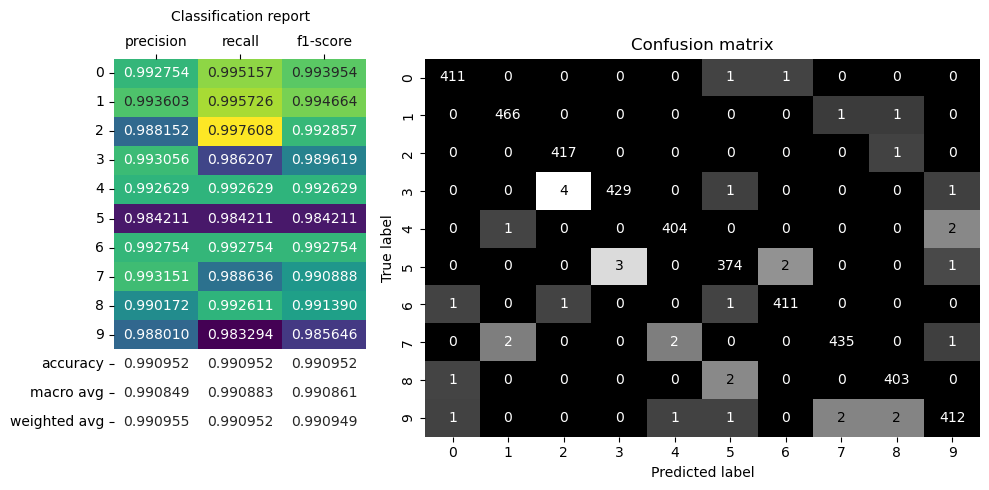

In [191]:
estimators_vt = [
    ('best_svc', best_svc['model']),
    ('best_knn', best_knn['model']),
    ('best_adb_hb', best_adb_hb['model']),
    ('best_hb', best_hb['model']),
    ('best_et', best_et['model']),
    ('best_rf', best_rf['model']),
]
pipe_vt = copy.copy(full_pipeline)
pipe_vt.set_params(model=VotingClassifier(estimators=estimators_vt, voting='soft', verbose=1, 
                                          weights=[10, 4, 3, 1, 1, 1]
                                         ))
pipe_vt.fit(X_train_des_aug, y_train_aug)
report_vt = EstimatorReport(pipe_vt, X_val_deskewed, y_val, [], [], "VotingClassifier")
report_vt.display_report()

# Submission <a class="anchor" id="submission"></a>

Let's evaluate our results on the test set and save it in submission dataframe.

In [208]:
def create_submissions(estimator, test_data, index_data, index_col, target_col):
    sumbission = pd.DataFrame(
        {
            index_col: index_data,
            target_col: estimator.predict(test_data),
        }
    ).set_index(index_col)
    sumbission.to_csv("submission.csv")
#     print("Submission file head:")
#     display(sumbission.head())

In [209]:
create_submissions(pipe_vt, test_data_deskewed, np.arange(1, len(test_data_deskewed)+1), 'ImageId', 'Label')

Submission file head:


,Label
ImageId,
1,2
2,0
3,9
4,0
5,3


# Conclusion <a class="anchor" id="conclusion"></a>
Solving the task without using neural networks showed relatively good performance. Preprocessing techniques and ensemble learning of the best classifiers allowed to reach a public score of 99.2%.